In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.mask import expand_mask
from bids import BIDSLayout, BIDSValidator

#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_run_trials_only'
#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_all_run_exploration'
#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_all_exploration'
#data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_run_trials_only'
# data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_all_exploration'
data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_all_run_exploration'

layout = BIDSLayout(data_dir, derivatives=True)

In [3]:
from nltools.utils import get_resource_path
from nltools.file_reader import onsets_to_dm
from nltools.data import Design_Matrix
import os

In [4]:
sub_num = 'sub-043'

## Exploration trials

In [5]:
E_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-E*.nii.gz'))
E_file_list.sort() 
E = Brain_Data(E_file_list)

N_file_list = glob.glob(os.path.join(data_dir,  'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-N*.nii.gz'))
N_file_list.sort()
N = Brain_Data(N_file_list)

W_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-W*.nii.gz'))
W_file_list.sort() 
W = Brain_Data(W_file_list)

S_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-S*.nii.gz'))
S_file_list.sort() 
S = Brain_Data(S_file_list)

In [6]:
data = E.append(N)
data = data.append(W)
data = data.append(S)

In [7]:
print(len(E.data))
print(len(N.data))
print(len(W.data))
print(len(S.data))

58
44
46
32


In [8]:
#Y = pd.DataFrame(np.hstack([np.zeros(157), np.ones(119),2*np.ones(122), 3*np.ones(97)]))
Y = pd.DataFrame(np.hstack([np.zeros(len(E.data)), np.ones(len(N.data)),2*np.ones(len(W.data)), 3*np.ones(len(S.data))]))

#Y = pd.DataFrame(np.hstack([np.zeros(42), np.ones(44)]))

data.Y = Y

In [9]:
data.shape


<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(180, 238955), Y=180, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])>

# Feature Selection - Whole Brain Analysis

In [10]:
# ------------------
# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 5% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [11]:
#############################################################################
# Fit the decoder and predict
# ----------------------------
anova_svc.fit(data.data, data.Y.values.ravel())
y_pred = anova_svc.predict(data.data)

In [12]:
#############################################################################
# Obtain prediction scores via cross validation
# -----------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation on the session group
# which corresponds to a leave-one-session-out
#cv = LeaveOneGroupOut()


# Compute the prediction accuracy for the different folds (i.e. session)
#cv_scores = cross_val_score(anova_svc, data.data, data.Y, cv=cv, groups=4)
cv_scores = cross_val_score(anova_svc, data.data, data.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))
# Classification accuracy:  0.70370 / Chance level: 0.5000


#############################################################################

Classification accuracy: 0.3000 / Chance level: 0.250000


# ROI - Retrosplenial

In [13]:
#data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_run_trials_only'
atlas_mni_file = os.path.join(data_dir,
                              "derivatives",
                              "data",
                              "Schaefer2018_100Parcels_17Networks_order_FSLMNI152_1mm.nii.gz")

threshold is ignored for simple axial plots


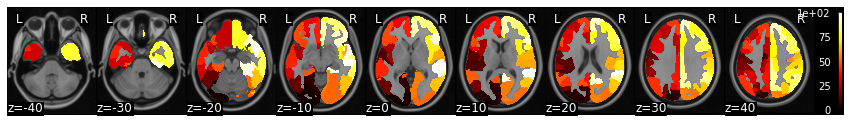

In [14]:
mask = Brain_Data(atlas_mni_file)
mask_x = expand_mask(mask)

f = mask.plot()

In [15]:
# index - 1 for all because this is python!!!
rsc = mask_x[[48-1,96-1]].sum() # retrosplenial cortex

data_masked = data.apply_mask(rsc)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [16]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [17]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2278 / Chandata_maskedce level: 0.250000


# ROI - Precuneus

In [18]:
# index - 1 for all because this is python!!!
pcun = mask_x[[35-1,36-1]].sum() # precuneus

data_masked = data.apply_mask(pcun)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [19]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [20]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2778 / Chandata_maskedce level: 0.250000


# ROI - Medial Parietal Lobe

In [21]:
# index - 1 for all because this is python!!!

mpar = mask_x[[24-1,73-1]].sum() # medial parietal lobe

data_masked = data.apply_mask(mpar)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [22]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [23]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2500 / Chandata_maskedce level: 0.250000


# ROI - Intraparietal Sulcus

In [24]:
# index - 1 for all because this is python!!!

ips = mask_x[[31-1,80-1]].sum() # intrapariental sulcus

data_masked = data.apply_mask(ips)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [25]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [26]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2500 / Chandata_maskedce level: 0.250000


# ROI - Extrastriate Cortex

In [27]:
# index - 1 for all because this is python!!!

ext = mask_x[[1-1,2-1,4-1,51-1,52-1,53-1]].sum() # extrastriate cortex

data_masked = data.apply_mask(ext)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [28]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [29]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.3389 / Chandata_maskedce level: 0.250000


# ROI - Parahippocampus

In [30]:
# index - 1 for all because this is python!!!

phc = mask_x[[49-1,97-1]].sum() # parahippocampus


data_masked = data.apply_mask(phc)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [31]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [32]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2778 / Chandata_maskedce level: 0.250000


# ROI - Somatomotor Cortex

In [33]:
# index - 1 for all because this is python!!!

som = mask_x[[8-1,9-1,10-1,11-1,12-1,13-1,57-1,58-1,59-1,60-1,61-1,62-1,63-1,64-1]].sum() # somatomotor



data_masked = data.apply_mask(som)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [34]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [35]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.3000 / Chandata_maskedce level: 0.250000


# ROI - Temporal + Temporoparietal lobe

In [36]:
# index - 1 for all because this is python!!!

temp = mask_x[[41-1,42-1,50-1, 98-1,99-1,100-1]].sum() # temporal lobe, temporal parietal lobe

data_masked = data.apply_mask(temp)

#svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [37]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [38]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

Classification accuracy: 0.2611 / Chandata_maskedce level: 0.250000
